# DATA UNDERSTANDING, CLEANING, AND PROCESSING

In [1]:
# Library Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("sickness_table.csv")

In [3]:
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


Column Description:

• date: entry date

• n_sick: number of drivers called sick on duty

• calls: number of emergency calls

• n_duty: number of drivers on duty available

• n_sby: number of standby resources available

• sby_need: number of standbys, which are activated on a given day

• dafted: number of additional drivers needed due to not enough standbys

In [5]:
# change column names
df.rename(
    columns={"date": "Date", 
             "n_sick": "drivers on duty that called in sick", 
             "calls": "emergency calls", 
             "n_duty": "drivers on duty available", 
             "n_sby": "standby resources available",
             "sby_need": "standby drivers activated",
             "dafted": "additional drivers needed due to not enough standbys"},
    inplace=True,
)

The project aims at minimizing dates with not enough standby drivers while having only standbys that will be used. Thus, the target variable for our model shall be number_of_standbys_activated

In [6]:
df.head()

,Unnamed: 0,Date,drivers on duty that called in sick,emergency calls,drivers on duty available,standby resources available,standby drivers activated,additional drivers needed due to not enough standbys
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            1152 non-null   int64  
 1   Date                                                  1152 non-null   object 
 2   drivers on duty that called in sick                   1152 non-null   int64  
 3   emergency calls                                       1152 non-null   float64
 4   drivers on duty available                             1152 non-null   int64  
 5   standby resources available                           1152 non-null   int64  
 6   standby drivers activated                             1152 non-null   float64
 7   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


In [8]:
# drop Unnamed column
df.drop(df.filter(regex="Unnamed"),axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 7 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Date                                                  1152 non-null   object 
 1   drivers on duty that called in sick                   1152 non-null   int64  
 2   emergency calls                                       1152 non-null   float64
 3   drivers on duty available                             1152 non-null   int64  
 4   standby resources available                           1152 non-null   int64  
 5   standby drivers activated                             1152 non-null   float64
 6   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 63.1+ KB


There are no null values in the data.

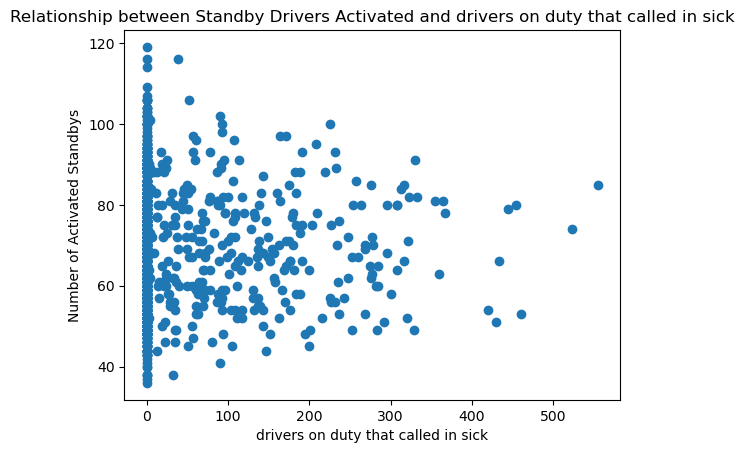

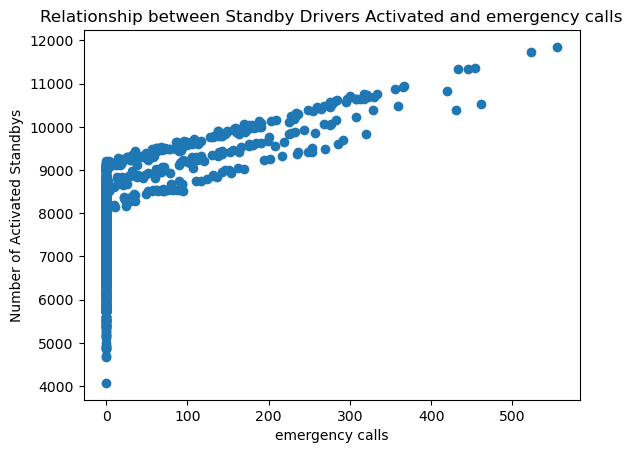

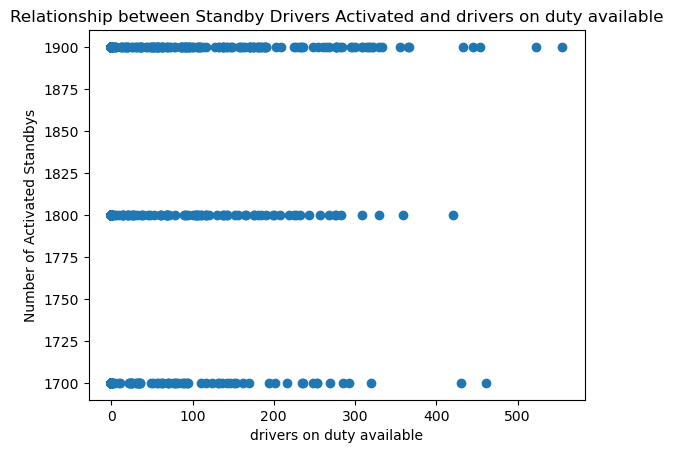

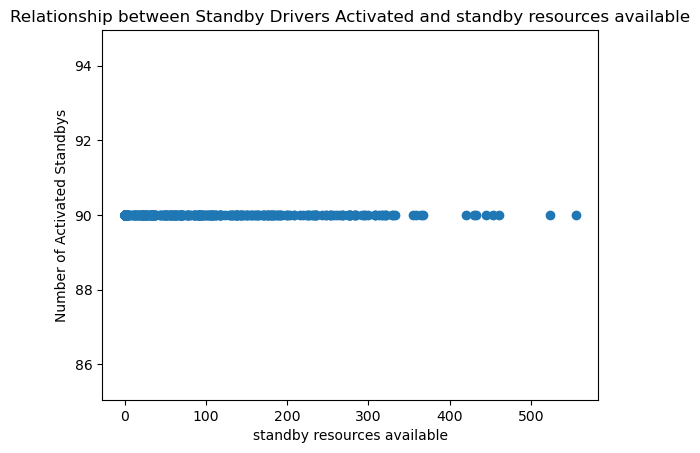

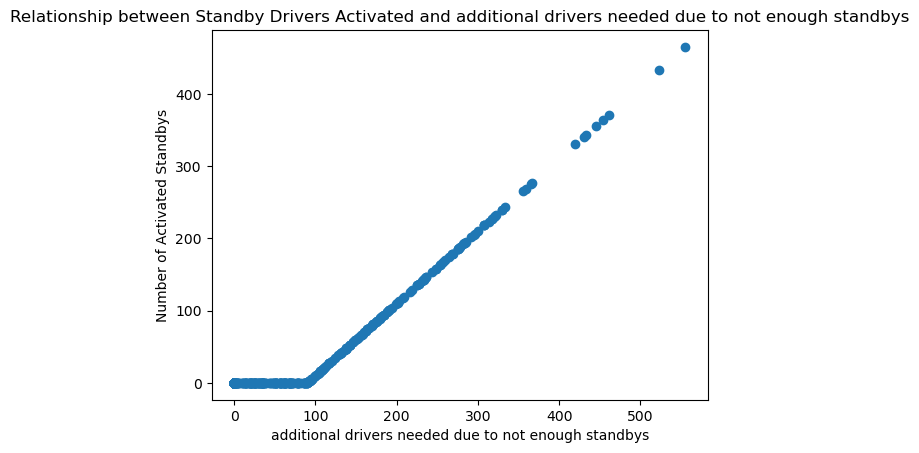

In [10]:
# Numerical columns
df_numerical_columns = df.drop(columns=['Date','standby drivers activated'])

# Relationship between the target variables and the numerical variables

for label in df_numerical_columns.columns:
  plt.scatter(df["standby drivers activated"], df_numerical_columns[label])
  plt.title(f'Relationship between Standby Drivers Activated and {label}')
  plt.ylabel("Number of Activated Standbys")
  plt.xlabel(label)
  plt.show()

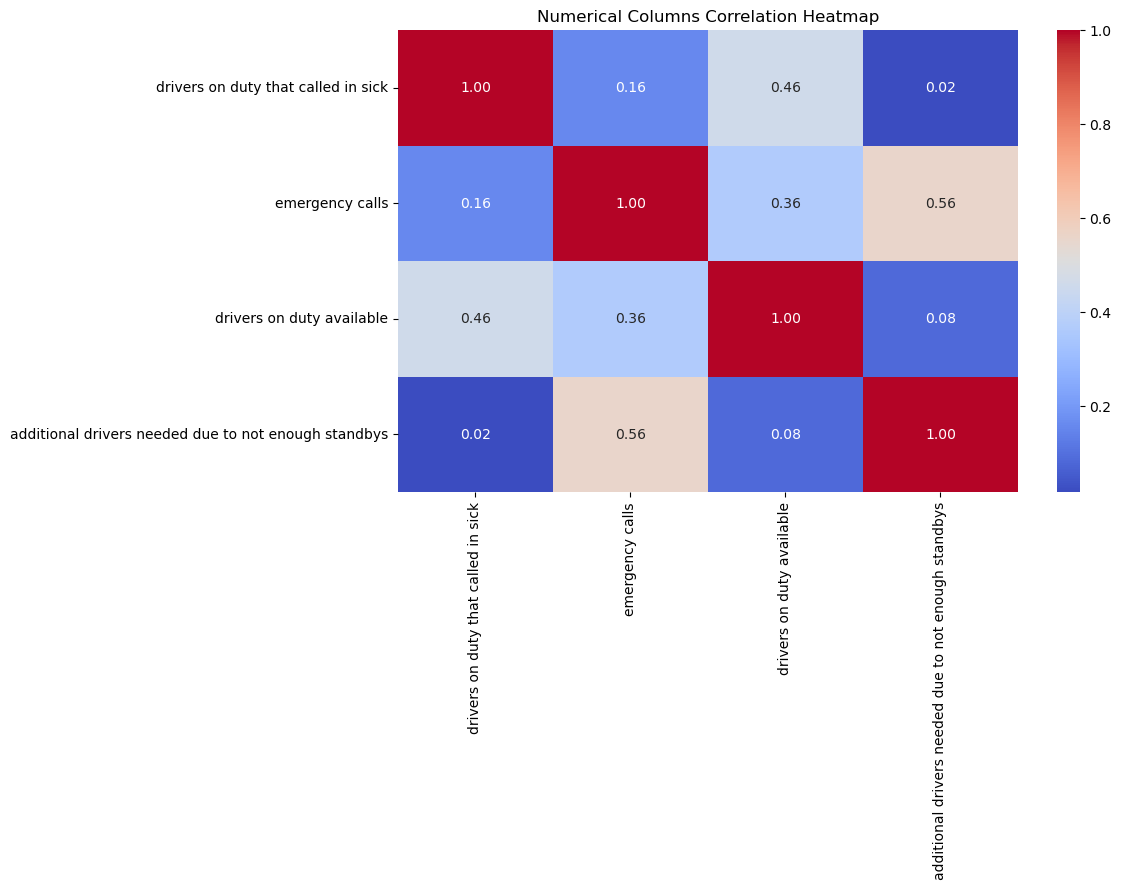

In [11]:
# Calculate correlation matrix
correlation_matrix = df_numerical_columns.drop(columns=['standby resources available']).corr()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Columns Correlation Heatmap')
plt.show()

There is a correlation between the number of emergency calls and the number of additional drivers needed due to not enough standby drivers. This correlation is expected because the higher the volume of calls, the higher the number of drivers needed and the higher the number of additional drivers needed. Therefore, keeping both variables adds unnecessary complexity. Thus, we will drop the number of emergency calls from the dataset.

In [12]:
# drop 'number_of_emergency_calls' from the dataset
df.drop(df.filter(regex="emergency calls"),axis=1, inplace=True)

In [13]:
# Convert 'Date' from string to date
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
# set date as index
df.index = pd.to_datetime(df['Date'])
df.drop(df.filter(regex="Date"),axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 5 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   drivers on duty that called in sick                   1152 non-null   int64  
 1   drivers on duty available                             1152 non-null   int64  
 2   standby resources available                           1152 non-null   int64  
 3   standby drivers activated                             1152 non-null   float64
 4   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 54.0 KB


Text(0, 0.5, 'Count')

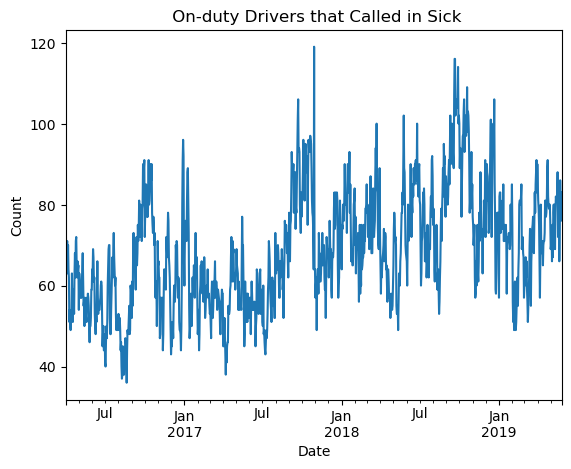

In [16]:
# Plot 'number_of_drivers_on_duty_that_called_in_sick' over time
df['drivers on duty that called in sick'].plot()
plt.title(' On-duty Drivers that Called in Sick')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

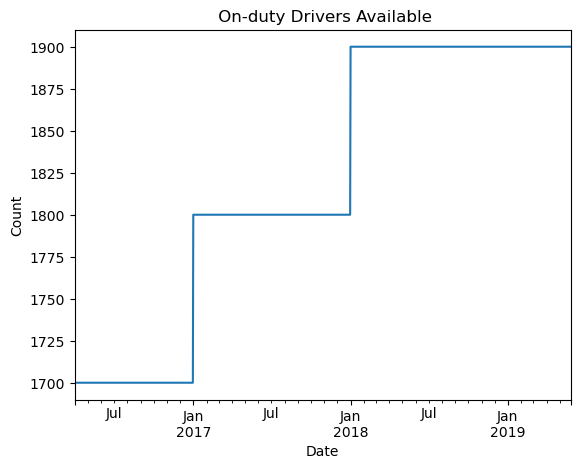

In [17]:
# Plot 'number_of_drivers_on_duty_available' over time
df['drivers on duty available'].plot()
plt.title(' On-duty Drivers Available')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

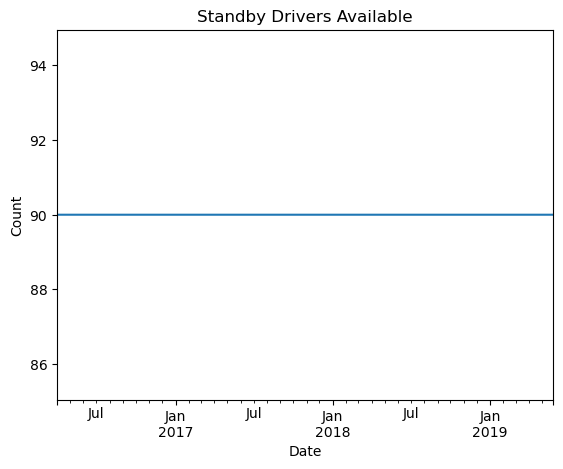

In [18]:
# Plot 'number_of_standby_resources_available' over time
df['standby resources available'].plot()
plt.title('Standby Drivers Available')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

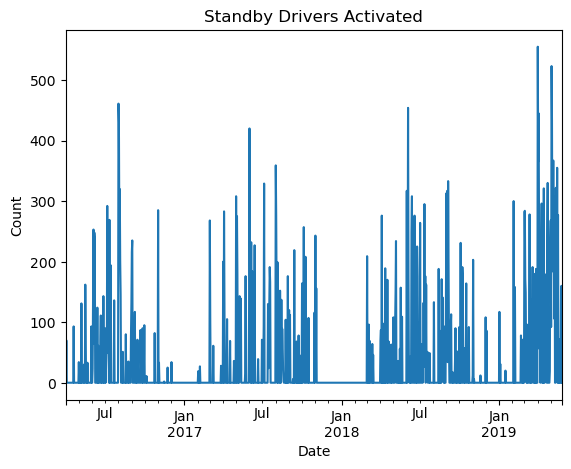

In [19]:
# Plot 'number_of_standbys_activated' over time
df['standby drivers activated'].plot()
plt.title('Standby Drivers Activated')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

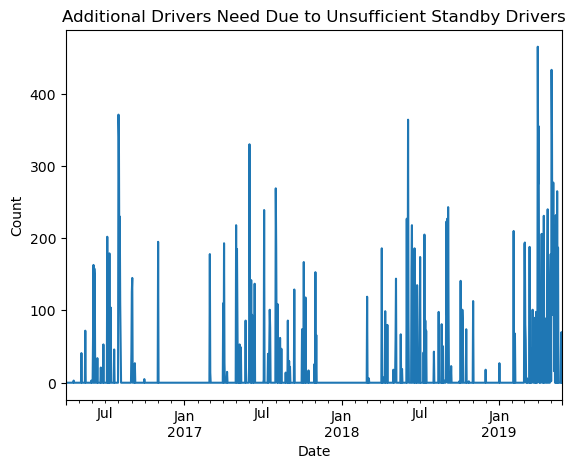

In [20]:
# Plot 'number_of_additional_drivers_needed_due_to_not_enough_standbys' over time
df['additional drivers needed due to not enough standbys'].plot()
plt.title('Additional Drivers Need Due to Unsufficient Standby Drivers')
plt.ylabel('Count')

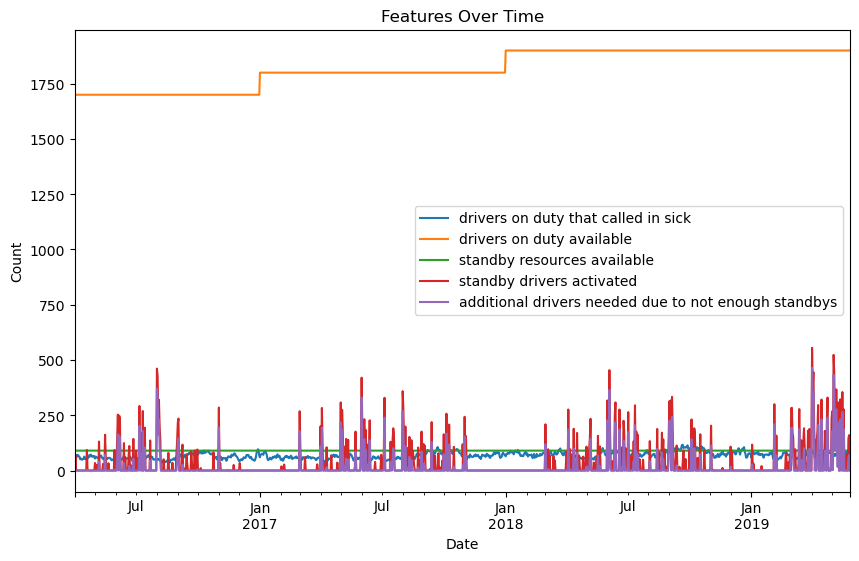

In [21]:
# Plot all variables over time
plt.figure(figsize=(10, 6))
for label in df.columns:
    df[label].plot()
    plt.title('Features Over Time')
    plt.ylabel('Count')
    plt.legend()

In [22]:
df.head()

,drivers on duty that called in sick,drivers on duty available,standby resources available,standby drivers activated,additional drivers needed due to not enough standbys
Date,,,,,
2016-04-01,73,1700,90,4.0,0.0
2016-04-02,64,1700,90,70.0,0.0
2016-04-03,68,1700,90,0.0,0.0
2016-04-04,71,1700,90,0.0,0.0
2016-04-05,63,1700,90,0.0,0.0


The fact that, regardless of the number of on-duty drivers calling in sick, the number of on-duty drivers available is almost always constant raises concern about the quality and veracity of the data. However, we will assume that when x on-duty drivers call in sick, x standby drivers are put on duty to replace those that called in sick and x non-standby drivers are put on standby to replace those that are now on duty.

In [26]:
# Create a new column called "month"
df['month'] = df.index.month

# Create a new column 'day' with the day of the month from the index
df['day of week'] = df.index.day

# Create a new column 'day of week' with the day of the week from the index (Monday is 0, Tuesday is 1, etc)
df['day of week'] = df.index.dayofweek

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   drivers on duty that called in sick                   1152 non-null   int64  
 1   drivers on duty available                             1152 non-null   int64  
 2   standby resources available                           1152 non-null   int64  
 3   standby drivers activated                             1152 non-null   float64
 4   additional drivers needed due to not enough standbys  1152 non-null   float64
 5   month                                                 1152 non-null   int64  
 6   day                                                   1152 non-null   int64  
 7   day of week                                           1152 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 81.

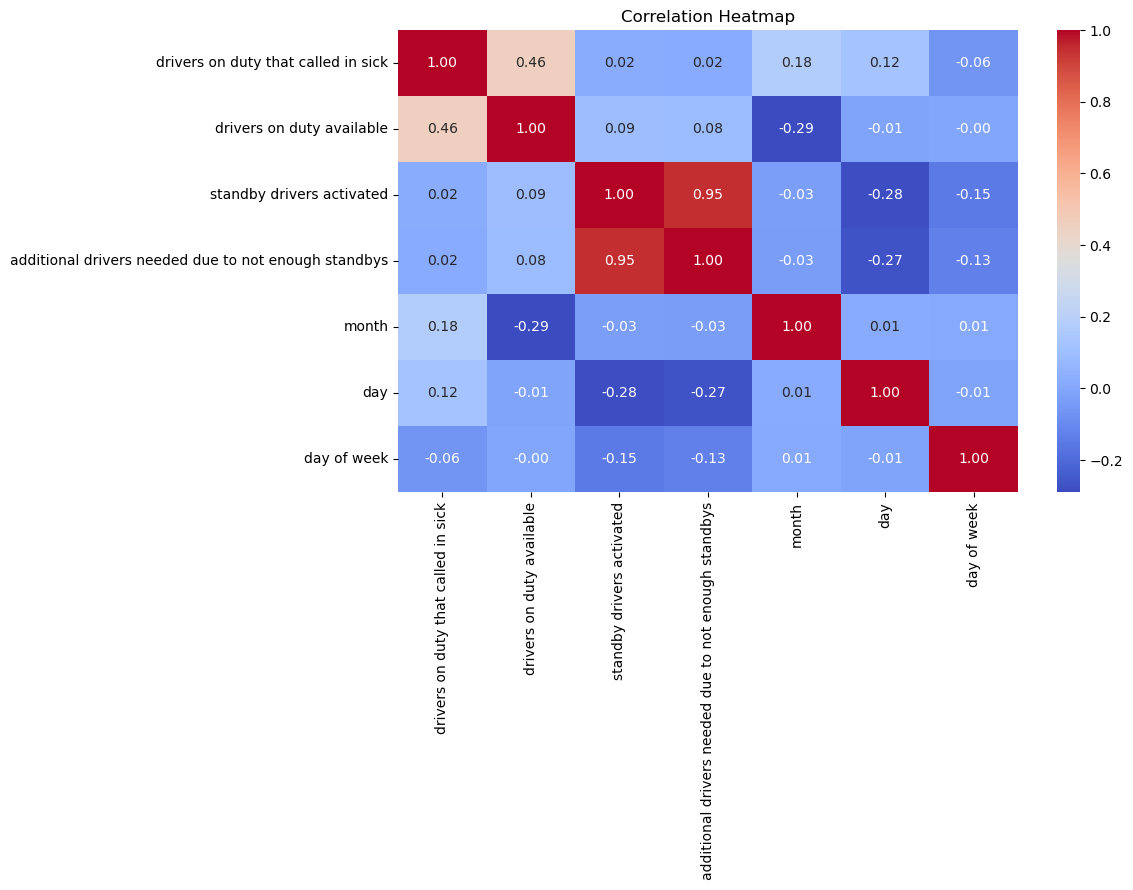

In [28]:
# Calculate correlation matrix
correlation_matrix = df.drop(columns=['standby resources available']).corr()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is a very strong correlation between the number of additional drivers needed due to not enough standby drivers
and the number of standby drivers activated. This is so because when additional drivers are needed, more standby drivers are activated.

These two variables are expected to be directly proportional. Nevertheless, we want to predict the number of standby drivers activates so that we can the predicted number of drivers on standby and ideally keep the additional drivers required to zero. 
In addition, this variable only exists because the number of standby drivers available is always 90. If we set this number based on the prediction for activated standby drivers, then we will be able to keep additional drivers to zero (or close to zero).

Thus, additional standby drivers is not a variable that we should use in the modeling process. Therefore, we will drop it.

Based on the understanding we have of the data, we expect that the number of additional drivers needed due to not enough standbys + the number of standby resources available is equal to the number of standbys activated, when the number of standbys activated is equal or greater than 90. When the number of standby activated is less than 90 (or the number of standby resources available), the number of additional drivers needed due to not enough standbys is expected to be zero.

If these assuptions/expectations are true, we will drop the number of additional drivers needed due to not enough standbys and the number of standby resources available because apart from being a strongly correlated variable and a constant, respectively, their value/number is already embedded in the target variable.  

In [29]:
df[['standby drivers activated','additional drivers needed due to not enough standbys','standby resources available']].head()

,standby drivers activated,additional drivers needed due to not enough standbys,standby resources available
Date,,,
2016-04-01,4.0,0.0,90
2016-04-02,70.0,0.0,90
2016-04-03,0.0,0.0,90
2016-04-04,0.0,0.0,90
2016-04-05,0.0,0.0,90


In [30]:
# Filter rows where 'number_of_standbys_activated' is greater than 90
filtered_df = df[df['standby drivers activated'] >= 90]
filtered_df['sum of additional and available standby drivers'] = filtered_df['additional drivers needed due to not enough standbys'] + filtered_df['standby resources available']

# Display only selected columns for the filtered DataFrame
result = filtered_df[['sum of additional and available standby drivers',
                      'standby drivers activated',
                      'additional drivers needed due to not enough standbys',
                      'standby resources available']]
result.head()

,sum of additional and available standby drivers,standby drivers activated,additional drivers needed due to not enough standbys,standby resources available
Date,,,,
2016-04-19,93.0,93.0,3.0,90
2016-05-07,131.0,131.0,41.0,90
2016-05-16,162.0,162.0,72.0,90
2016-05-30,93.0,93.0,3.0,90
2016-06-03,154.0,154.0,64.0,90


The expectations/assumptions hold true. Thus, the two columns mentioned above shall be dropped from the dataset.

In [31]:
# Drop additional drivers needed due to not enough standbys and standby resources available
df = df.drop(columns=['additional drivers needed due to not enough standbys','standby resources available'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   drivers on duty that called in sick  1152 non-null   int64  
 1   drivers on duty available            1152 non-null   int64  
 2   standby drivers activated            1152 non-null   float64
 3   month                                1152 non-null   int64  
 4   day                                  1152 non-null   int64  
 5   day of week                          1152 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 63.0 KB


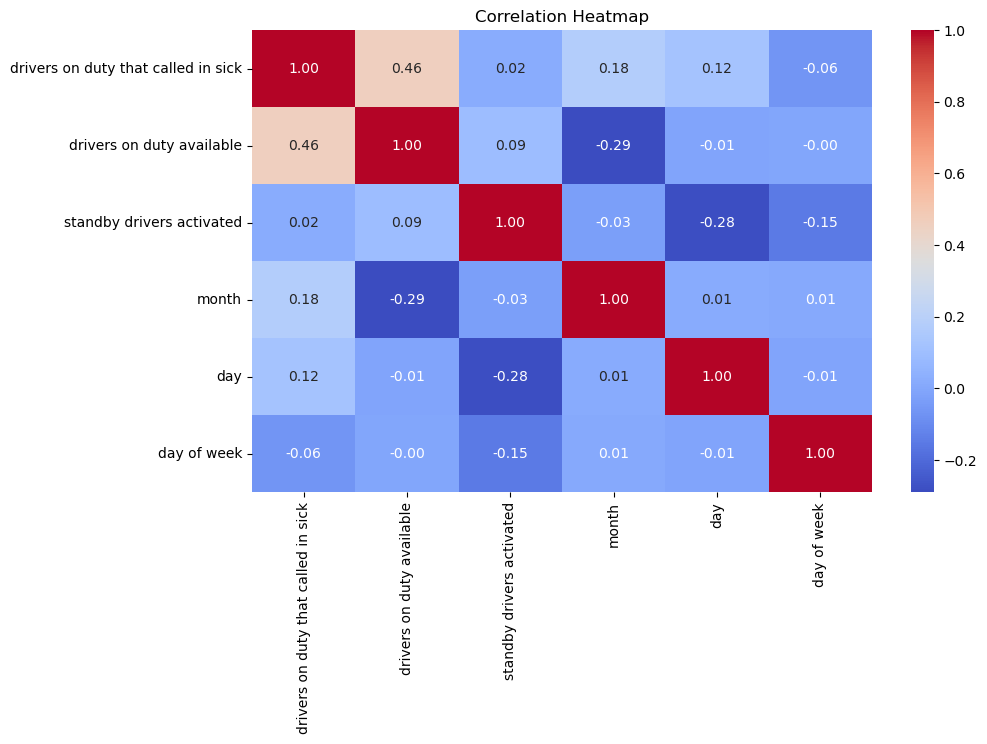

In [32]:
# Calculate correlation matrix
correlation_matrix2 = df.corr()   

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Model Building

We are interested in predicting the number of standby drivers activated. 
As demonstrated, there are temporal patterns in the data and there are independent features that do have some impact on the target feature.
We will use time series models to predict the number of on-duty drivers that called in sick and the number of on-duty drivers that are available.
The output from these models and the intended month, day of the week, and day of the month shall be fed into a regression model that will predict the number of standby drivers activated.

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Split the data into features and target variable
X = df.drop(["standby drivers activated"], axis=1)
y = df['standby drivers activated']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Baseline model: Use mean of training labels as prediction
baseline_prediction = np.mean(y_train)

# Evaluate baseline model
baseline_predictions = np.full_like(y_test, baseline_prediction)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_r2 = r2_score(y_test, baseline_predictions)

print("Baseline Mean Squared Error:", baseline_mse)
print("Baseline R^2 Score:", baseline_r2)

Baseline Mean Squared Error: 3948.0596391092417
Baseline R^2 Score: -0.04265361361883846


In [36]:
# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Mean Squared Error:", mse_lr)
print("Linear Regression R^2 Score:", r2_lr)


Linear Regression Mean Squared Error: 3731.357597016259
Linear Regression R^2 Score: 0.01457580739310127


In [37]:
# Instantiate the decision tree regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Train the decision tree model
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the decision tree model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Mean Squared Error:", mse_dt)
print("Decision Tree R^2 Score:", r2_dt)

Decision Tree Mean Squared Error: 9369.839826839827
Decision Tree R^2 Score: -1.474506022580866


In [38]:
# Instantiate the Random Forest regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
random_forest.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R^2 Score:", r2_rf)

Random Forest Mean Squared Error: 4491.148002597402
Random Forest R^2 Score: -0.18607926988198198


In [39]:
# Instantiate the SVR model
svr = SVR(kernel='rbf')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.

# Train the SVR model
svr.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr.predict(X_test)

# Evaluate the SVR model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR Mean Squared Error:", mse_svr)
print("SVR R^2 Score:", r2_svr)

SVR Mean Squared Error: 4384.761138826878
SVR R^2 Score: -0.15798327891642017


In [40]:
# Instantiate the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the regularization strength by changing alpha

# Train the Ridge Regression model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the Ridge Regression model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Mean Squared Error:", mse_ridge)
print("Ridge Regression R^2 Score:", r2_ridge)

Ridge Regression Mean Squared Error: 3731.3106395456107
Ridge Regression R^2 Score: 0.014588208516927548


In [41]:
# Instantiate the Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the regularization strength by changing alpha

# Train the Lasso Regression model
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the Lasso Regression model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Mean Squared Error:", mse_lasso)
print("Lasso Regression R^2 Score:", r2_lasso)

Lasso Regression Mean Squared Error: 3723.036455805182
Lasso Regression R^2 Score: 0.016773359797633725


In [42]:
# Instantiate the MultiLayerPerceptronRegressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the MLPRegressor model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the MLPRegressor model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regression Mean Squared Error:", mse_mlp)
print("MLP Regression R^2 Score:", r2_mlp)

MLP Regression Mean Squared Error: 3579.929639970283
MLP Regression R^2 Score: 0.05456682096667731


In [46]:
model_evaluation = pd.DataFrame({"mse":[baseline_mse, mse_lr, mse_dt, mse_rf, mse_svr, mse_ridge, mse_lasso, mse_mlp],
                                 "r2":[baseline_r2, r2_lr, r2_dt, r2_rf, r2_svr, r2_ridge, r2_lasso, r2_mlp],
                                 "label":["Baseline", "Linear Regression", "Decision Tree", "Random Forest",
                                          "SVR", "Ridge Regression", "Lasso Regression", "MLP Regression"]})

In [47]:
model_evaluation.head(20)

,mse,r2,label
0,3948.059639,-0.042654,Baseline
1,3731.357597,0.014576,Linear Regression
2,9369.839827,-1.474506,Decision Tree
3,4491.148003,-0.186079,Random Forest
4,4384.761139,-0.157983,SVR
5,3731.310640,0.014588,Ridge Regression
6,3723.036456,0.016773,Lasso Regression
7,3579.929640,0.054567,MLP Regression


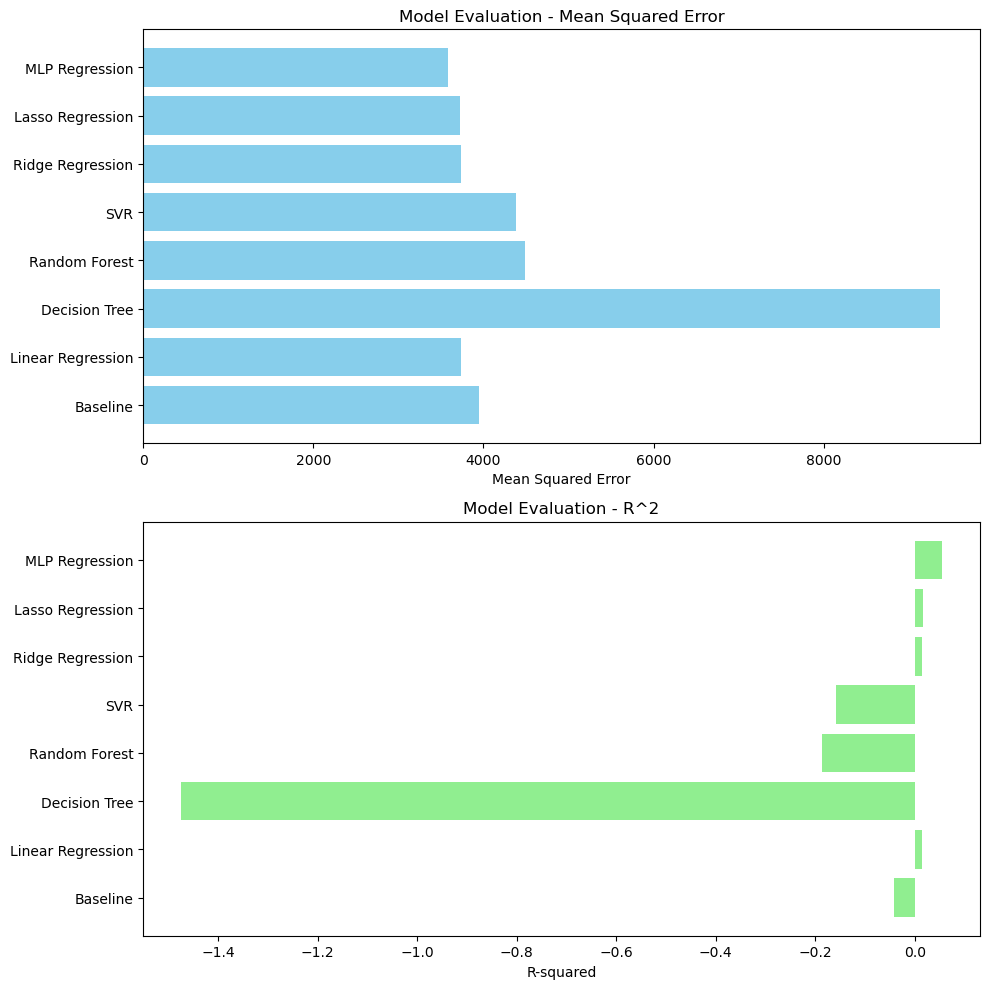

In [48]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# MSE plot
ax1.barh(model_evaluation['label'], model_evaluation['mse'], color='skyblue')
ax1.set_xlabel('Mean Squared Error')
ax1.set_title('Model Evaluation - Mean Squared Error')

# R^2 plot
ax2.barh(model_evaluation['label'], model_evaluation['r2'], color='lightgreen')
ax2.set_xlabel('R-squared')
ax2.set_title('Model Evaluation - R^2')

plt.tight_layout()
plt.show()

Based on the results, Decision Tree is the best performing model. Therefore, we will use it.